In [1]:
"""
AR(1) model using default LLY method
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization
This example gives an introduction of core functionalities of `linkalman`. The first of the two primary inputs for `linkalman` models is a user-defined function that define system dynamics. Note that here we have `my_f`: `theta` -> `M`, because we are assuming constant model, and T provided by BaseConstantModel (BCM) by other means. In addition, BCM calculates unconditional means and covariances directly, and automatically generated Dt if not provided by users. 
    
If users want to use BaseOpt, they must provide a mapping such as `my_ft : (theta, T, **kwargs) -> Mt`, where:
    
```
Mt = {'Ft': Ft, 'Qt': Qt, 'Ht': Ht, 'Rt': Rt, 'Bt': Bt, 'Dt': Dt, 'xi_1_0': xi_1_0, 'P_1_0': P_1_0}
```

The output must be a dictionary and contains all the keys. The values for `Ft`, `Qt`, `Bt`, `Ht`, `Dt`, and `Rt` are a list of matrices of length T. In other words, Mt must provide the system matrics from 0 up to time T. `xi_1_0` and `P_1_0` are initial state means and covariances matrices, respectively. `Mt` define a BSTS model. 

In [2]:
def my_f(theta):
    """
    AR(1) model. In general, MLE is biased, so the focus should be 
    more on prediction fit, less on parameter estimation. The 
    formula here for Ar(1) is:
    y_t = c + Fy_{t-1} + epsilon_{t-1}
    """
    # Define theta
    phi_1 = 1 / (np.exp(theta[0])+1)  # ensure less than 1
    sigma = np.exp(theta[1]) 
    # Generate F
    F = np.array([[phi_1]])
    # Generate Q
    Q = np.array([[sigma]]) 
    # Generate R, set to 0 to be consistent with AR(1) process
    R = np.array([[0]])
    # Generate H
    H = np.array([[1]])
    # Generate B
    B = np.array([[theta[2]]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R, 'B': B}

    return M


The second of the two primary inputs is a solver object. Here I use `scipy` optimizers to build: 

```
my_soler: (param, obj_func, **kwargs) -> (theta_opt, fval_opt)
```

It effectively takes initial `param`, objective function `obj_func`, and optional `**kwargs` as inputs and produces optimal parameter `theta_opt` and function evaluation `fval_opt` as outputs. Any solver function should have such setup for `linkalman` to use. Here the `obj_func` is provided by `linkalman`. Note that since `linkalman` provides loglikelihood functions, we should modify the objective function if needed.

In [3]:
def my_solver(param, obj_func, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    res = minimize(obj_, param, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
        
    return theta_opt, fval_opt

Now let's initialize a `BaseConstantModel` (`BCM`) model. Use `model.set_f` and `model.set_solver` to plug in `my_f` and `my_solver`. Note that since we use `BCM`, which under the hood invokes `linkalman.core.utils.ft`, the keyword arguments in `model.set_f` are for `ft`.  

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, x_0=x * np.ones([1, 1]))
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-8, 'disp': True}) 

# Generate Synthetic Data
Now let's generate some synthetic data using `model.simulated_data`. I also split the data set into training set and test set. In addition, for the last bit of dataset, I mark them all as `np.nan` (meaning missing) to test the model's performance in forecasting instead of typical nowcasting in test data. Users of `linkalman` may use either the full data, or only the test data, if the initial state values are properly configured. I will illustrate this later. 

In [5]:
# Some initial parameters
theta = np.array([-1, -0.1, 1])
T = 365
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

# If we want AR(1) with non-zero stationary mean, we should proivde a constant 
x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  # use x to ensure constant model

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict
Let's fit the AR(1) model using the `LLY` method. Here, `model.fit` will take the input DataFrame, some initial guess, and column name of measurements `y_col` and of regressors `x_col`. After the model is optimized, I use `model.predict` to compute $\hat{y}_{t|t-1} \equiv E(y_t|y_1,y_2,...y_{t-1}, x_1,x_2,...,x_t;\theta)$. Note that we can also provide a specific `theta` into `model.predict` to generate customized predictions.

I also create a confidence interval at 95% for $\hat{y}_{t|t-1}$ (since we have full measurements arcoss all times, smoothed estimate $\hat{y}_{t|T}$ are just $y_t$ and are omitted here. We will discuss $\hat{y}_{t|T}$ in more details with AR(1) examples with missing measurements.

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)

Optimization terminated successfully.
         Current function value: 215.278493
         Iterations: 156
         Function evaluations: 276


# Check Model Performance
We can now check the performance of our model against both the actuals as well as the model prediction when using true $\theta$. Let's first plot $\hat{y}_{t|t-1}$ with confident intervals. Here I will just make some very simple plots, but with the output from the fitted models (for example `model.ks_fitted` contains the state estimates from both the filtering and smoothing process) one may build sophisticated analysis pipeline. 

In [7]:
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

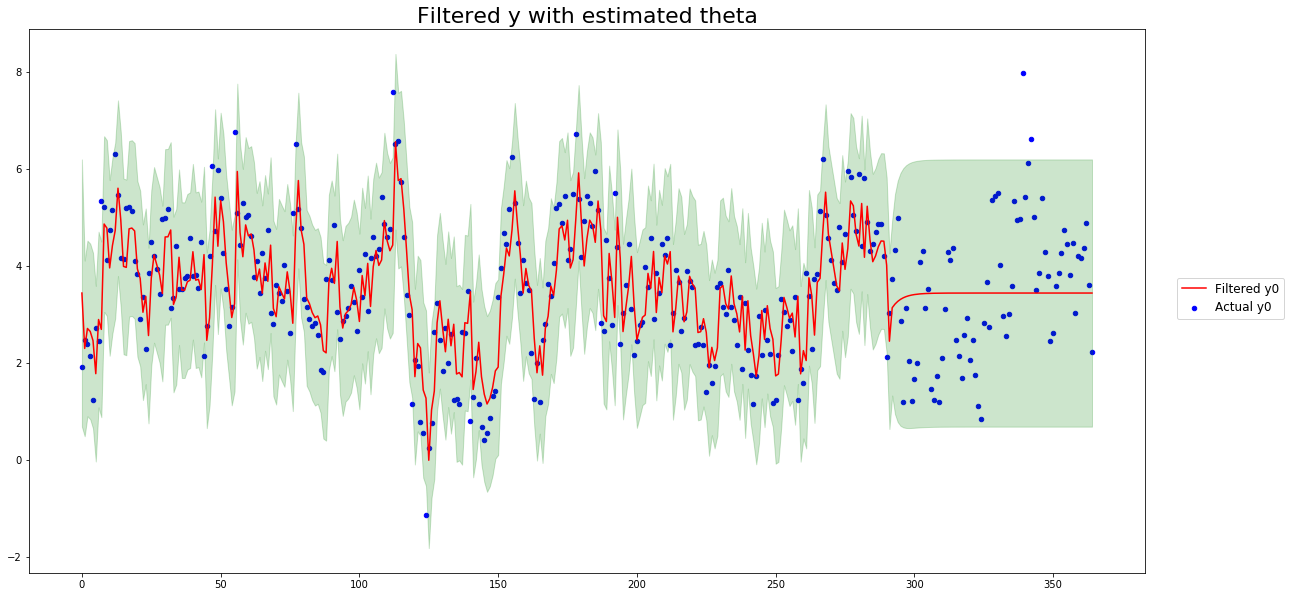

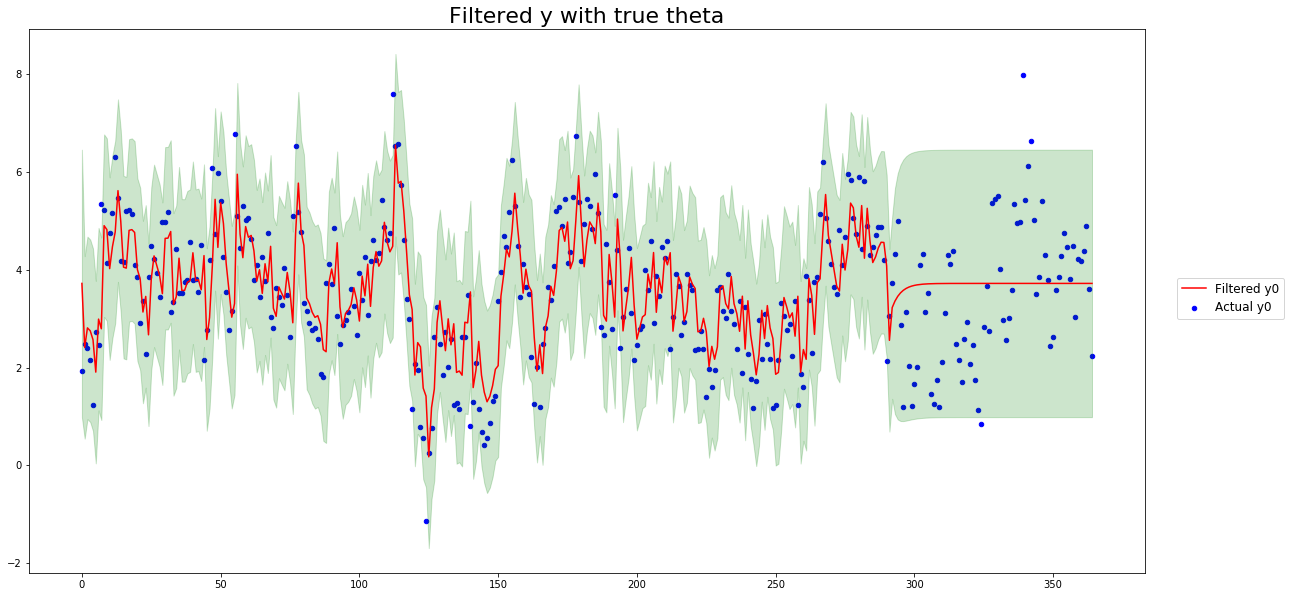

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')

The plot shows the predition using fitted theta and true theta are very similar. We can verify this by looking at some metrics. Overall, the fitted theta has very similar performance as the true theta in terms of RMSE. The mean_error is a more noisy metrics. 

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 0.9281226129957496, 'mean_error': -0.004476662613000027}
Ture theta for training data: {'RMSE': 0.9300162313563438, 'mean_error': 0.06927120066097402}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 0.9377623625485226, 'mean_error': -0.16466444336729022}
Ture theta for test data: {'RMSE': 0.9351692643688287, 'mean_error': -0.10545169208482966}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 1.4486232277773585, 'mean_error': -0.07604173314704955}
Ture theta for forecast data: {'RMSE': 1.4505475244431993, 'mean_error': 0.1893892325331289}


# Prediction without Training Data
Finally, `linkalman.models.BaseOpt.predict_t` allows starting prediction not from time index 0 (as determined by training data), but rather pick any time from 0 to T (note that training data ends with time index T-1), as long as the state at time t is not a diffuse state. This improvement allows lightweight model predictions. Instead of loading the entire dataset, users may just pick a starting time index t, and feed in data with first observation labeled with timestamp t. `t_index=-1` here means using T as the staring time index. You can see both generate exactly the same results.

In [13]:
df_test_only
df_LLY_test_only = model.predict_t(df_test_only, t_index=-1)

is_test_only = df_LLY_test_only.index < forecast_t
is_forecast_only = ~is_test_only

print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for test data only: {}'.format(
    summary_stats(df_LLY_test_only[is_test_only], 'y_0_filtered', 'y_0_vis')))

print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for forecast data only: {}'.format(
    summary_stats(df_LLY_test_only[is_forecast_only], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 0.9377623625485226, 'mean_error': -0.16466444336729022}
LLY theta for test data only: {'RMSE': 0.9377623625485226, 'mean_error': -0.16466444336729022}
LLY theta for forecast data: {'RMSE': 1.4486232277773585, 'mean_error': -0.07604173314704955}
LLY theta for forecast data only: {'RMSE': 1.4486232277773585, 'mean_error': -0.07604173314704955}
